In [1]:
import keras
%matplotlib inline

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


We review 3 advanced RNN techniques
- **Recurrent dropout:** using dropout to fit overfitting in recurring layers
- **Stacking recurrent layers:** increasing the representational power of the network
- **Bidirectional recurrent layers:** present the same information to a recurrent network in different ways

We will apply all three to a temperature forecasting problem. We'll use meteorological data to build a model that takes as input some data from the recent past (a few days’ worth of data points) and predicts the air temperature 24 hours in the future.

In [4]:
import os

data_dir = "/home/ec2-user/datasets/jena_climate/"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [3]:
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [5]:
# Import into Numpy
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

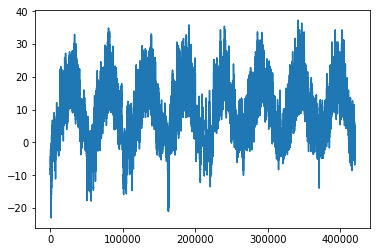

In [5]:
from matplotlib import pyplot as plt
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

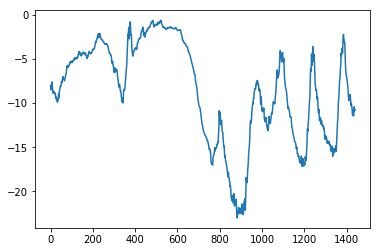

In [6]:
# and now just plotting the first 10 days (data recorded every 10 minutes)
plt.plot(range(1440), temp[:1440])

When we look at the data over a long period of time, we see that there is periodicity, but when we look at just some days, we see that the data is quite chaotic. Can we use this data to predict on a daily scale?

Specifically, given data going as far back as `lookback` timesteps (a timestep is 10 minutes) and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps? We will use these values:
- `lookback: 720`(Observations go back 5 days)
- `steps: 6` (Observations will be sampled at 1 data point per hour)
- `delay: 144` (Targets will be 24 hours in future)

In [6]:
# As a first step, we normalise the data, so that all variables
# are of a similar magnitude
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [22]:
# Then we need to write a generator that takes the current array of float data and yields
# batches of data from the recent past, along with a target temperature in the future. It yields a tuple 
# (samples, targets), where samples is one batch of input data and targets is the corresponding array 
# of target temperatures.

In [7]:
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets           

In [8]:
# We now use this generic generator to instantiate three generators, one for training
# one for validation and one for test
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# How many steps to draw from val_gen in order to see the entire validation set
val_steps = (300000 - 200001 - lookback)
# How many steps to draw from test_gen in order to see the entire test set
test_steps = (len(float_data) - 300001 - lookback)

### Naive baseline

In [35]:
# Using a naive baseline - we assume that the temperature is the same as 24 hours before
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.289695115591


In [38]:
# The measure had been normalised, we can re-express this in celsius by multiplying
celsius_mae =  0.289695115591 * std[1]
print(celsius_mae)

2.56452574489


### Basic machine learning approach

In [15]:
# We use a simple densely connected network. Note that the last dense layer does not 
# have an activation function, which is typical of the regression cases
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1]))) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='RMSprop', loss=['mae'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps // batch_size)

Epoch 1/20
500/500 [==============================] - 16s 31ms/step - loss: 1.1876 - val_loss: 0.6107
Epoch 2/20
500/500 [==============================] - 15s 31ms/step - loss: 0.4149 - val_loss: 0.3611
Epoch 3/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2904 - val_loss: 0.3074
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2633 - val_loss: 0.2977
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2519 - val_loss: 0.3281
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2439 - val_loss: 0.3127
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2375 - val_loss: 0.3282
Epoch 8/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2323 - val_loss: 0.3273
Epoch 9/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2273 - val_loss: 0.3247
Epoch 10/20
500/500 [==============================] - 15s 31ms/step - loss: 0.223

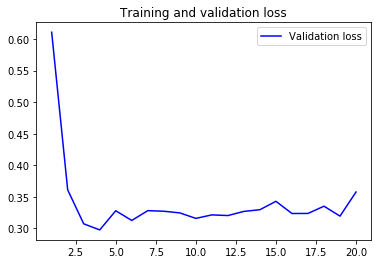

In [18]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# We can see that we can not even beat the 'naive' baseline.

### A recurrent baseline

The fully connected approach didn't work so well, so now we try using a recurrent network for the first time, given that the data is after all a sequence, and that order matters. Instead of using a LSTM layer we will use a **GRU** (Gated recurrent unit) layer, which are a bit cheaper to run.

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.fit_generator(train_gen,
                   steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps // batch_size)

Epoch 1/20
500/500 [==============================] - 210s 419ms/step - loss: 0.3042 - val_loss: 0.2711
Epoch 2/20
500/500 [==============================] - 208s 416ms/step - loss: 0.2861 - val_loss: 0.2706
Epoch 3/20
500/500 [==============================] - 209s 417ms/step - loss: 0.2798 - val_loss: 0.2689
Epoch 4/20
500/500 [==============================] - 208s 415ms/step - loss: 0.2757 - val_loss: 0.2640
Epoch 5/20
500/500 [==============================] - 208s 415ms/step - loss: 0.2706 - val_loss: 0.2663
Epoch 6/20
500/500 [==============================] - 208s 416ms/step - loss: 0.2676 - val_loss: 0.2694
Epoch 7/20
500/500 [==============================] - 209s 417ms/step - loss: 0.2627 - val_loss: 0.2693
Epoch 8/20
500/500 [==============================] - 207s 415ms/step - loss: 0.2597 - val_loss: 0.2743
Epoch 9/20
500/500 [==============================] - 207s 414ms/step - loss: 0.2544 - val_loss: 0.2681
Epoch 10/20
500/500 [==============================] - 207s 414m

KeyboardInterrupt: 

In [12]:
# We can see that we beat the common sense baseline with a MAE of ~0.264, compared a MAE of ~0.29.
# But there is still quite a bit of margin to go.
# Note however that the model starts overfitting quite early on.

### Using recurrent dropout to beat overfitting

We can add `dropout` (a float specifying the dropout rate for input units of the layer) and `recurrent_dropout`, speficifying the dropout rate for the recurrent units as follows

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=10,
                             validation_data=val_gen,
                             validation_steps=val_steps // batch_size)

Epoch 1/10
500/500 [==============================] - 249s 497ms/step - loss: 0.3370 - val_loss: 0.2756
Epoch 2/10
500/500 [==============================] - 249s 497ms/step - loss: 0.3149 - val_loss: 0.2739
Epoch 3/10
500/500 [==============================] - 248s 497ms/step - loss: 0.3075 - val_loss: 0.2694
Epoch 4/10
500/500 [==============================] - 250s 501ms/step - loss: 0.3043 - val_loss: 0.2722
Epoch 5/10
500/500 [==============================] - 248s 496ms/step - loss: 0.2992 - val_loss: 0.2672
Epoch 6/10
500/500 [==============================] - 248s 496ms/step - loss: 0.2975 - val_loss: 0.2692
Epoch 7/10
500/500 [==============================] - 248s 497ms/step - loss: 0.2952 - val_loss: 0.2675
Epoch 8/10
500/500 [==============================] - 249s 498ms/step - loss: 0.2940 - val_loss: 0.2661
Epoch 9/10
500/500 [==============================] - 250s 500ms/step - loss: 0.2929 - val_loss: 0.2636
Epoch 10/10
500/500 [==============================] - 248s 497m

In this case we no longer see evidence of overfitting. However, the performance is not much better than the best one that we obtained with the recurrent network without dropout.  

### Stacking recurrent layers

Given that we are no longer overfitting and we seem to have hit a **performance bottleneck**, what we can do at this stage is to **increase the capacity of the network**. We can do that by stacking recurrent layers on top of each other. As follows:

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps // batch_size)

Epoch 1/20
500/500 [==============================] - 545s 1s/step - loss: 0.3321 - val_loss: 0.2828
Epoch 2/20
500/500 [==============================] - 545s 1s/step - loss: 0.3061 - val_loss: 0.2757
Epoch 3/20
500/500 [==============================] - 539s 1s/step - loss: 0.2962 - val_loss: 0.2715
Epoch 4/20
500/500 [==============================] - 544s 1s/step - loss: 0.2895 - val_loss: 0.2681
Epoch 5/20
500/500 [==============================] - 541s 1s/step - loss: 0.2842 - val_loss: 0.2636
Epoch 6/20
500/500 [==============================] - 529s 1s/step - loss: 0.2801 - val_loss: 0.2656
Epoch 7/20
500/500 [==============================] - 551s 1s/step - loss: 0.2746 - val_loss: 0.2697
Epoch 8/20
500/500 [==============================] - 580s 1s/step - loss: 0.2706 - val_loss: 0.2624
Epoch 9/20
500/500 [==============================] - 574s 1s/step - loss: 0.2671 - val_loss: 0.2672
Epoch 10/20
500/500 [==============================] - 559s 1s/step - loss: 0.2653 - val_lo

We can see that adding the extra layer does improve the results a bit but not significantly. There is still no overfitting, so we could draw the following two conclusions:
* we could increase the size of the layers to improve validation loss, but this carries a significant computational cost
* as adding a layer did not help by a significant factor, we may see diminishing returns from increasing network capacity at this point

### Using bidirectional RNNs

A bidirectional RNN consists of two regular RNNs (such as GRU or LSTM layers), each of which **processes the input sequence in one direction (chronologically and anti-chronologically)** and then merging their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

However, we note that if we run the temperature model in anti-chronological order, we get a much worse performance. So using this approach for this objective is unlikely to lead to an improvement in performance. Moreover, as there are more trainable parameters, there is a higher risk of overfitting. In any case, such a network would be implemented as follows:

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps // batch_size)

Epoch 1/10
500/500 [==============================] - 455s 911ms/step - loss: 0.2953 - val_loss: 0.2818
Epoch 2/10
500/500 [==============================] - 495s 990ms/step - loss: 0.2723 - val_loss: 0.2649
Epoch 3/10
500/500 [==============================] - 447s 893ms/step - loss: 0.2641 - val_loss: 0.2662
Epoch 4/10
500/500 [==============================] - 502s 1s/step - loss: 0.2596 - val_loss: 0.2745
Epoch 5/10
500/500 [==============================] - 438s 876ms/step - loss: 0.2542 - val_loss: 0.2722
Epoch 6/10
500/500 [==============================] - 446s 891ms/step - loss: 0.2449 - val_loss: 0.2762
Epoch 7/10
500/500 [==============================] - 471s 941ms/step - loss: 0.2378 - val_loss: 0.2776
Epoch 8/10
500/500 [==============================] - 535s 1s/step - loss: 0.2325 - val_loss: 0.2782
Epoch 9/10
500/500 [==============================] - 528s 1s/step - loss: 0.2269 - val_loss: 0.2883
Epoch 10/10
500/500 [==============================] - 453s 907ms/step - 

In the book, we can see that this type of approach can actually work ok for the IMDB classification problem, and in general bidirectional RNNs are used in NLP tasks. (See example pages 220-221)